In [1]:
import json
import pandas as pd
import os

def files_to_df(dir_name):
    
    full_df = pd.DataFrame() # initialize full df compilation of files
    files = os.listdir(dir_name) # get list of files in directory
    print(f"{len(files)} files found in {dir_name}: {files}")

    for i in files:
        filename = os.path.join(dir_name, i)
        with open(filename, 'r') as f:
            data = json.loads(json.load(f))['data']
            df = pd.DataFrame(data)
        full_df = pd.concat([full_df, df], ignore_index = True) # join current json file to full df

    return full_df

In [2]:
cyberpunk_df = files_to_df('raw_data/cyberpunk')


133 files found in raw_data/cyberpunk: ['data_1.json', 'data_115.json', 'data_36.json', 'data_61.json', 'data_98.json', 'data_77.json', 'data_103.json', 'data_20.json', 'data_57.json', 'data_123.json', 'data_16.json', 'data_41.json', 'data_119.json', 'data_82.json', 'data_94.json', 'data_95.json', 'data_83.json', 'data_118.json', 'data_40.json', 'data_17.json', 'data_122.json', 'data_56.json', 'data_21.json', 'data_102.json', 'data_99.json', 'data_76.json', 'data_60.json', 'data_37.json', 'data_114.json', 'data_51.json', 'data_125.json', 'data_10.json', 'data_133.json', 'data_47.json', 'data_84.json', 'data_92.json', 'data_109.json', 'data_129.json', 'data_7.json', 'data_113.json', 'data_30.json', 'data_88.json', 'data_67.json', 'data_71.json', 'data_105.json', 'data_26.json', 'data_27.json', 'data_104.json', 'data_70.json', 'data_89.json', 'data_66.json', 'data_31.json', 'data_112.json', 'data_6.json', 'data_128.json', 'data_108.json', 'data_93.json', 'data_85.json', 'data_46.json', '

In [3]:
print(cyberpunk_df.shape)
cyberpunk_df.head(5)

(9973, 8)


,hash_id,hide_as_adult,icons,id,smaller_square_cover_url,title,url,user
0,nW6bO,False,"{'video': True, 'image': True, 'model3d': Fals...",788851,https://cdna.artstation.com/p/assets/images/im...,Cyberpunk Alley,https://www.artstation.com/artwork/nW6bO,"{'id': 138129, 'username': 'dorubutz', 'medium..."
1,r3WA5,False,"{'video': False, 'image': True, 'model3d': Fal...",2913788,https://cdnb.artstation.com/p/assets/images/im...,cyberpunk,https://www.artstation.com/artwork/r3WA5,"{'id': 96007, 'username': 'fanhuang', 'medium_..."
2,JleONm,False,"{'video': False, 'image': True, 'model3d': Fal...",4024584,https://cdna.artstation.com/p/assets/covers/im...,CYBERPUNK K/DA,https://www.artstation.com/artwork/JleONm,"{'id': 447219, 'username': 'gharly', 'medium_a..."
3,W2aPkG,True,"{'video': False, 'image': True, 'model3d': Fal...",3762625,https://cdnb.artstation.com/p/assets/images/im...,CYBERPUNK,https://www.artstation.com/artwork/W2aPkG,"{'id': 3958, 'username': 'evanlee82', 'medium_..."
4,30YRm,False,"{'video': False, 'image': True, 'model3d': Fal...",3039489,https://cdna.artstation.com/p/assets/images/im...,cyberpunk2,https://www.artstation.com/artwork/30YRm,"{'id': 96007, 'username': 'fanhuang', 'medium_..."


In [4]:
# convert dataframe back to json and export it
export = cyberpunk_df.to_json("full_data/cyberpunk.json")
print("Export complete.")

Export complete.


In [4]:
import time
import requests

def pause_report(length, random_delay, file_count, disp = True):
    
    pause_time = length*np.random.normal(1,random_delay)
    if disp: print(f"Downloaded {file_count} images. Pausing scraper for {round(pause_time,2)} seconds.")
    time.sleep(pause_time)

    
def download_files(my_dir, df, file_start, file_end, short_pause = 2, long_pause = 60, random_delay = 0.25):

    file_count = 0 #number of files downloaded
    alrdy_exists = 0 #number of files that already exist and are skipped over
    skipped_urls = {} #urls that can't be connected to - need to retry at a later time
    
    for i in range(file_start, file_end):

        if i >= len(df):
            print(f"Index {i} does not exist in dataframe.")
            print("End of dataframe has probably been reached. Process is terminating.")
            return 0
        
        filename = f"{my_dir}/{df['hash_id'][i]}.jpg" # name the image using its hash_id

        if not os.path.exists(filename): # skip over files that have been downloaded
            
            try:
                img_url = df['smaller_square_cover_url'][i]
                print(f'Downloading {img_url} as {filename}')
                
                f = open(filename,'wb')
                f.write(requests.get(img_url).content)
                f.close()

                file_count += 1

                # take a short pause per url scraped
                pause_report(short_pause, random_delay, file_count)
                
            except:
                print("Cannot establish connection with the following row in df:")
                print(f"{i}:{img_url}")
                print("Skipping to next row")
                skipped_urls[i] = img_url #add key value pair to skipped_urls dict
                
                if len(skipped_urls) > 10:
                    print("More than 10 urls have had connection error.")
                    print(skipped_urls)
                    pause_report(300, random_delay, file_count) # pause for 5 minutes if more than 10 urls with connection error
                       
        else: 
            print(f"{filename} already exists. Skipping to next image url in df.")
            alrdy_exists += 1
            
        # take a long pause if 100 images have been downloaded
        if file_count > 0 and file_count%100 == 0:
            pause_report(long_pause, random_delay, file_count)
            
        # take a long pause x 2 if 500 images have been downloaded
        if file_count > 0 and file_count%500 == 0:
            pause_report(long_pause*2, random_delay, file_count)
      
    # Retry skipped urls
    print(f"Skipped the following urls because failed to make a connection:")
    print(skipped_urls)
    
    if len(skipped_urls) > 0:
        print("Retrying skipped urls.")
        
        for index, url in skipped_urls.items():
            try:
                filename = f"{my_dir}/{df['hash_id'][index]}.jpg"
                print(f'Downloading {url} as {filename}.')

                f = open(filename,'wb')
                f.write(requests.get(img_url).content)
                f.close()

                file_count += 1

                # take a short pause per url scraped
                pause_report(short_pause, random_delay, file_count)

            except Exception as e:
                print("Still unable to connect to skipped urls. Please manually check for error.")
                print(e.message, e.args)
                return 0
    
    print(f"{file_count} images downloaded.")
    print(f"Skipped {alrdy_exists} images because already exists in database.")
    print("Process finished.")
    return 1
    

In [5]:
download_files('images/cyberpunk', cyberpunk_df, 9700, 10000)

images/cyberpunk/xzDB5W.jpg already exists. Skipping to next image url in df.
images/cyberpunk/XolVD.jpg already exists. Skipping to next image url in df.
images/cyberpunk/w8NmXw.jpg already exists. Skipping to next image url in df.
images/cyberpunk/KPq5x.jpg already exists. Skipping to next image url in df.
images/cyberpunk/qwKqz.jpg already exists. Skipping to next image url in df.
images/cyberpunk/gJo8XZ.jpg already exists. Skipping to next image url in df.
images/cyberpunk/L2lmDA.jpg already exists. Skipping to next image url in df.
images/cyberpunk/58oLlA.jpg already exists. Skipping to next image url in df.
images/cyberpunk/xzyO41.jpg already exists. Skipping to next image url in df.
images/cyberpunk/Yaobx3.jpg already exists. Skipping to next image url in df.
images/cyberpunk/Bmkxgl.jpg already exists. Skipping to next image url in df.
images/cyberpunk/4xNBl.jpg already exists. Skipping to next image url in df.
images/cyberpunk/5AgaJ.jpg already exists. Skipping to next image ur

0

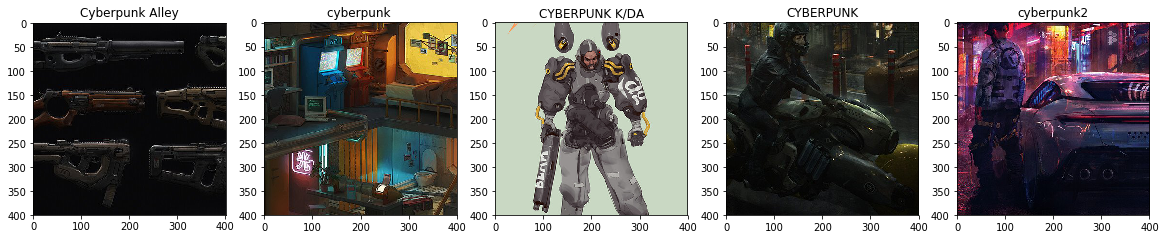

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(20,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = mpimg.imread(f"images/cyberpunk/{cyberpunk_df['hash_id'][i+60]}.jpg")
    plt.title(f"{cyberpunk_df['title'][i]}")
    plt.imshow(img)
    
    